# Visitor Prediction in the Library of buisness administration (BWI)

**Lecture:** Selected Topics in AI<br>
**Lecturer:** Prof. Dr. Johannes Maucher

**Group:**
- Firaz Ilhan
- Patryk Gadziomski

<div style="width: 100%; height: 30px; background-color:red"></div>

In [16]:
from matplotlib import pyplot as plt
import pandas as pd
from meteostat import Point, Daily
import datetime
import seaborn as sns
import torch
import torchtime.data

## 1. Data Exploration

In [17]:
# Read excel file as dataframe: visitor_data
visitor_data = pd.read_excel("data/new_data.xlsx")
visitor_data.iloc[:5, :]

,timestemp,value
0,2022-03-28 09:30:00,NaN
1,2022-03-28 10:45:00,NaN
2,2022-03-28 13:45:00,NaN
3,2022-03-28 16:15:00,NaN
4,2022-03-28 17:45:00,NaN


In [18]:
visitor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4896 entries, 0 to 4895
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestemp  4896 non-null   datetime64[ns]
 1   value      318 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 76.6 KB


In [19]:
visitor_data.columns = [str(column) for column in visitor_data.columns]
visitor_data.columns

Index(['timestemp', 'value'], dtype='object')

<Axes: xlabel='timestemp'>

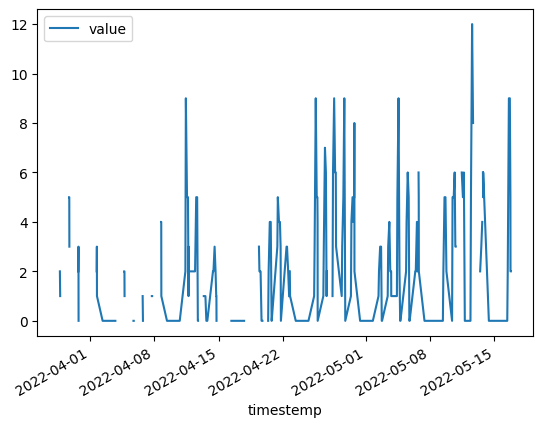

In [20]:
# Visualize the times
# plt.figure(figsize=(15, 7))

# category = ['09:30:00', '10:45:00', '13:45:00', '16:15:00', '17:45:00']
# total_subplots = len(category)

# rows = (total_subplots // 4) + 1
# cols = min(total_subplots, 4)

# for i, col in enumerate(category):
#     plt.subplot(rows, cols, i + 1)
#     sns.lineplot(y=visitor_data[col], x=visitor_data["date"])
#     plt.title(f'Lineplot of {col}')

# plt.tight_layout()  # Adjusts the plots to fit into the figure area.
# plt.show()

# Becasue of the missing values, we have a lot of gaps/random zeros




visitor_data.plot(x="timestemp", y="value")

## 2. Data Preprocessing

- Man könnte alle Daten erfassen (auch wenn nicht in der Statistik) damit dem Model kalr wird, dass am Wochende bzw. Feiertagen keiner kommt
- Missing Values mit 
    - Median
    - k-Nearest Neighbors

- Prüfungsphase
- Weekend & Holiday



- Neue datenstruktur:
    - Firaz: ab August
    - Patryk: älter als August

In [21]:
# add column "weekday"
# fill "weekday" with weekdays in relation to the date
days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"] 
visitor_data["weekday"] = [days[weekday] for weekday in visitor_data["timestemp"].dt.dayofweek]
visitor_data

,timestemp,value,weekday
0,2022-03-28 09:30:00,NaN,monday
1,2022-03-28 10:45:00,NaN,monday
2,2022-03-28 13:45:00,NaN,monday
3,2022-03-28 16:15:00,NaN,monday
4,2022-03-28 17:45:00,NaN,monday
...,...,...,...
4891,2023-11-29 16:15:00,NaN,wednesday
4892,2023-11-29 17:45:00,NaN,wednesday
4893,2023-11-29 18:00:00,NaN,wednesday
4894,2023-11-29 18:30:00,NaN,wednesday


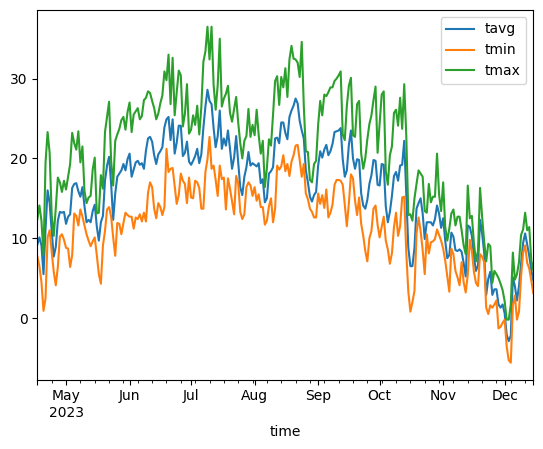

In [26]:
# Get the weather data until today
today_year = int(str(datetime.datetime.today())[0:4])
today_month = int(str(datetime.datetime.today())[5:7])
today_day = int(str(datetime.datetime.today())[8:10])

# get weather data thorught the date
start = datetime.datetime(2023, 4, 17)
end = datetime.datetime(today_year, today_month, today_day)

# Stuttgart
location = Point(48.7823200, 9.1770200, 252)

weather_data = Daily(location, start, end)
weather_data = weather_data.fetch()

"""
time: The date string (format: YYYY-MM-DD)      : String
tavg: The average air temperature in °C         : Float
tmin: The minimum air temperature in °C         : Float
tmax: The maximum air temperature in °C	        : Float
prcp: The daily precipitation total in mm       : Float
snow: The maximum snow depth in mm	            : Integer
wdir: The average wind direction in degrees (°)	: Integer
wspd: The average wind speed in km/h	        : Float
wpgt: The peak wind gust in km/h	            : Float
pres: The average sea-level air pressure in hPa	: Float
tsun: The daily sunshine total in minutes (m)	: Integer
"""
weather_data

weather_data.plot(y=['tavg', 'tmin', 'tmax'])
plt.show()

In [29]:
# merge data frames
joined_df = visitor_data.merge(
    weather_data,
    left_on="timestemp",
    right_on="time" # Die Uhrzeiten müssen auch passen | Muss man fixen
)

joined_df

,timestemp,value,weekday,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun


## 3. Build Model

In [ ]:
print(visitor_data.shape)

(171, 10)
